Se carga el dataset que se utilizara

In [1]:
from pandas import DataFrame
import pandas as pd

dataset =  DataFrame(pd.read_csv('potatoeseries.csv', header=None))
print(dataset.head)

<bound method NDFrame.head of       0
0     7
1     7
2     7
3     7
4     7
5     7
6     7
7     7
8     7
9     7
10    7
11    7
12    7
13    7
14    7
15    7
16    7
17    7
18    7
19    7
20    7
21    7
22    7
23    7
24    7
25    7
26    7
27    7
28    7
29    7
...  ..
1859  8
1860  8
1861  8
1862  8
1863  8
1864  8
1865  8
1866  8
1867  8
1868  8
1869  8
1870  8
1871  8
1872  8
1873  8
1874  8
1875  8
1876  8
1877  8
1878  8
1879  8
1880  8
1881  8
1882  8
1883  8
1884  8
1885  8
1886  8
1887  8
1888  8

[1889 rows x 1 columns]>


Se aplica media movil en los datos.

In [2]:
from matplotlib import pyplot

dataset_soft = dataset.rolling(window=8, min_periods=1).mean()

pyplot.figure(num=None, figsize=(18, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.style.use("ggplot")
pyplot.plot(dataset[1:150], label='Input')
pyplot.plot(dataset_soft[1:150], label='Soft')
pyplot.title('Media móvil Aplicada')
pyplot.legend()
pyplot.show()

<Figure size 5760x1920 with 1 Axes>

Se define el tamaño de ventana que tendra la serie de tiempos, y se transforma a una colección de datos para el entrenamiento supervisado de la red.

In [3]:
import Tools as tls

size = 5

dataset_serialized = tls.series_to_supervised(dataset_soft,size, n_out=1, dropnan = True)
print(dataset_serialized)

      var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
5           7.0        7.0        7.0        7.0        7.0      7.0
6           7.0        7.0        7.0        7.0        7.0      7.0
7           7.0        7.0        7.0        7.0        7.0      7.0
8           7.0        7.0        7.0        7.0        7.0      7.0
9           7.0        7.0        7.0        7.0        7.0      7.0
10          7.0        7.0        7.0        7.0        7.0      7.0
11          7.0        7.0        7.0        7.0        7.0      7.0
12          7.0        7.0        7.0        7.0        7.0      7.0
13          7.0        7.0        7.0        7.0        7.0      7.0
14          7.0        7.0        7.0        7.0        7.0      7.0
15          7.0        7.0        7.0        7.0        7.0      7.0
16          7.0        7.0        7.0        7.0        7.0      7.0
17          7.0        7.0        7.0        7.0        7.0      7.0
18          7.0        7.0        

Se normalizan los datos entre 0 y 1

In [4]:
from sklearn import preprocessing

datasetnorm = preprocessing.minmax_scale(dataset_serialized, feature_range=(0, 1))
datasetnorm = DataFrame(datasetnorm)
print(datasetnorm)

             0         1         2         3         4         5
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
5     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
6     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
7     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
8     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
9     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
10    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
11    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
12    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
13    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
14    0.000000  0.000000 

Preparamos los datos para alimentar la red para entrenamiento y prueba.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

zy = datasetnorm.iloc[:, -1:]
zx = datasetnorm.iloc[:, :-1].values
X = np.array(zx, dtype='float64')
y = np.array(zy, dtype='float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=20)

print(X_train.shape, y_train.shape) 

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1]))

print(X_train.shape, y_train.shape) 

(1318, 5) (1318, 1)
(1318, 1, 5) (1318, 1, 1)


Contruimos nuestro modelo y compilamos

In [6]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(8, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2]))) # importante declarar correctamente shape
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam', metrics=['mse'])

Using TensorFlow backend.


Entrenamos nuestro modelo y guardamos datos en "history"

In [7]:
history = model.fit(X_train, y_train, epochs=50, batch_size=24, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 1318 samples, validate on 566 samples
Epoch 1/50
1318/1318 [==============================] - 4s 3ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/50
1318/1318 [==============================] - 0s 107us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 8.7601e-04 - val_mean_squared_error: 8.7601e-04
Epoch 3/50
1318/1318 [==============================] - 0s 111us/step - loss: 7.7268e-04 - mean_squared_error: 7.7268e-04 - val_loss: 4.8505e-04 - val_mean_squared_error: 4.8505e-04
Epoch 4/50
1318/1318 [==============================] - 0s 119us/step - loss: 5.4461e-04 - mean_squared_error: 5.4461e-04 - val_loss: 3.9648e-04 - val_mean_squared_error: 3.9648e-04
Epoch 5/50
1318/1318 [==============================] - 0s 107us/step - loss: 4.7710e-04 - mean_squared_error: 4.7710e-04 - val_loss: 3.6167e-04 - val_mean_squared_error: 3.6167e-04
Epoch 6/50
1318/1318 [==============================] - 0s 119us/step

Epoch 46/50
1318/1318 [==============================] - 0s 119us/step - loss: 5.6241e-05 - mean_squared_error: 5.6241e-05 - val_loss: 7.1771e-05 - val_mean_squared_error: 7.1771e-05
Epoch 47/50
1318/1318 [==============================] - 0s 107us/step - loss: 5.5545e-05 - mean_squared_error: 5.5545e-05 - val_loss: 7.1586e-05 - val_mean_squared_error: 7.1586e-05
Epoch 48/50
1318/1318 [==============================] - 0s 107us/step - loss: 5.4863e-05 - mean_squared_error: 5.4863e-05 - val_loss: 7.1157e-05 - val_mean_squared_error: 7.1157e-05
Epoch 49/50
1318/1318 [==============================] - 0s 119us/step - loss: 5.4191e-05 - mean_squared_error: 5.4191e-05 - val_loss: 7.0530e-05 - val_mean_squared_error: 7.0530e-05
Epoch 50/50
1318/1318 [==============================] - 0s 111us/step - loss: 5.3548e-05 - mean_squared_error: 5.3548e-05 - val_loss: 6.9783e-05 - val_mean_squared_error: 6.9783e-05


Graficamos...

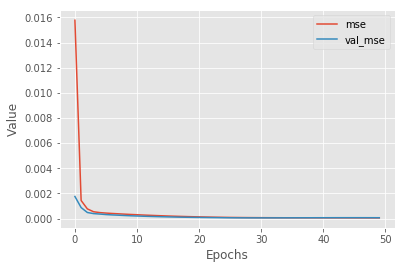

In [8]:
pyplot.style.use("ggplot")
pyplot.plot(history.history['mean_squared_error'], label='mse')
pyplot.plot(history.history['val_mean_squared_error'], label='val_mse')
pyplot.xlabel('Epochs')
pyplot.ylabel('Value')
pyplot.legend()
pyplot.show()

Se realiza una predicción con los datos de prueba, y estos son comparados.

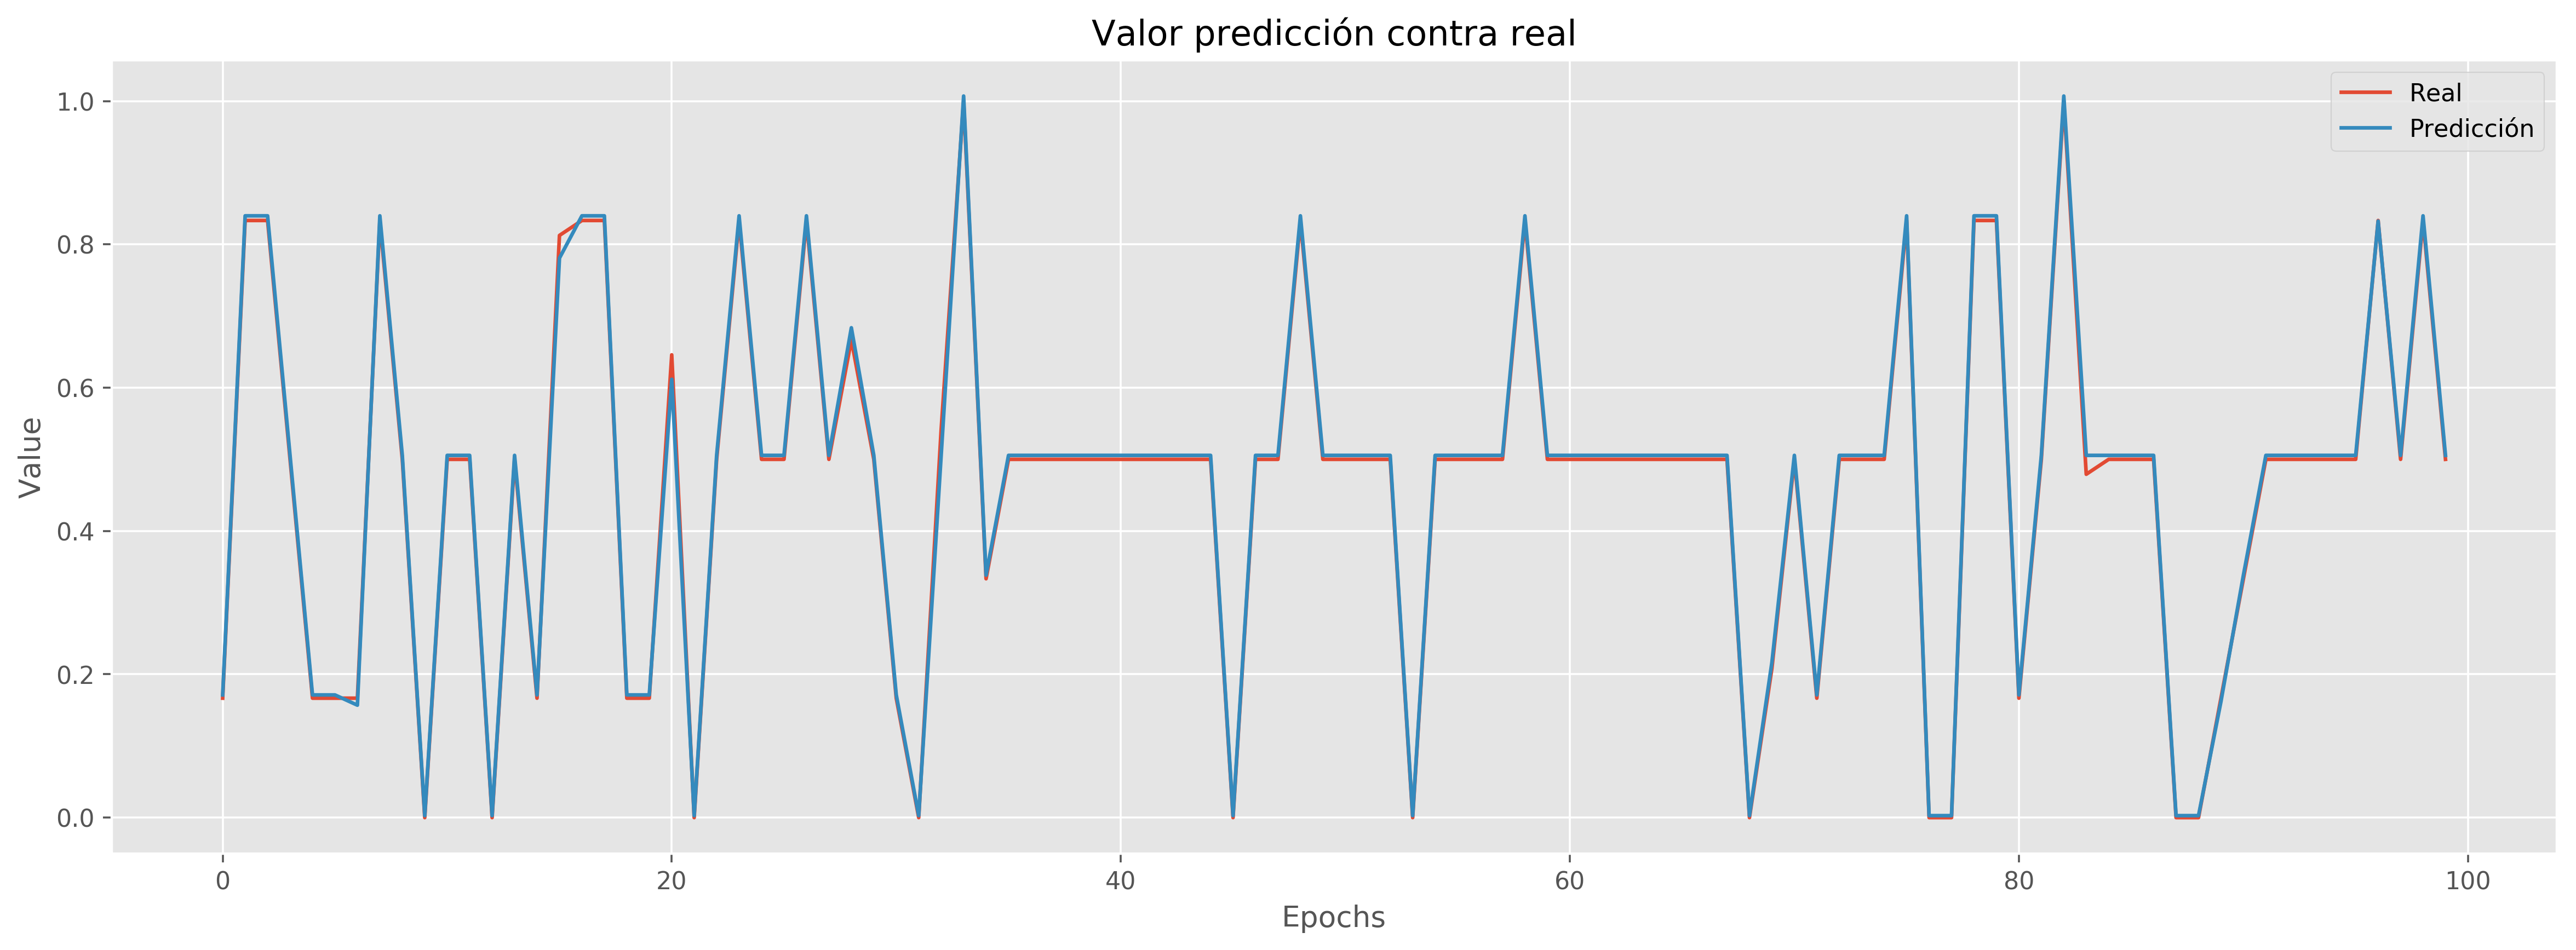

In [9]:
predictions = model.predict(X_test, 10, verbose=2)
predicted = predictions.transpose(2,0,1).reshape(-1,predictions.shape[1])
y_test = y_test.transpose(2,0,1).reshape(-1,y_test.shape[1])

pyplot.figure(num=None, figsize=(18, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.plot(y_test[0:100,], label='Real')
pyplot.plot(predicted[0:100,], label='Predicción')
pyplot.title('Valor predicción contra real')
pyplot.xlabel('Epochs')
pyplot.ylabel('Value')
pyplot.legend()
pyplot.show()